In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist
import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from utils import plot_mnist 

%matplotlib inline


In [7]:
path='./FashionMNIST_data'

train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transforms.ToTensor())
train_mean = (train_data.train_data.float().mean()/255).item()
train_std = (train_data.train_data.float().std()/255).item()
print('Mean: {}'.format(train_mean), type(train_mean))
print('Std: {}'.format(train_std), type(train_std))

Mean: 0.28604060411453247 <class 'float'>
Std: 0.35302427411079407 <class 'float'>


In [8]:
fashion_mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((train_mean,), (train_std,)),
           ])

In [9]:
def fashionmnist(batch_size=50, valid=0, shuffle=True, transform=fashion_mnist_transform, path='./FashionMNIST_data'):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


In [10]:
train_loader, valid_loader, test_loader = fashionmnist(valid=10000)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-3, l2=0.):#-3
#    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):        
        super(Net, self).__init__()
#        self.fc1 = nn.Linear(28*28, 128)
        self.fc1 = nn.Linear(28*28, 256)

        self.fc2 = nn.Linear(256, 256)
        self.fc2_1 = nn.Linear(256, 256) #256 256       
        self.fc2_2 = nn.Linear(256, 128) #256 128               
        
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        
#        self.optim = optim.Adam(self.parameters(), lr=lr)        
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2_1(x))        
        x = F.relu(self.fc2_2(x))                
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [12]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    train_losses = [0]*len(models) #
    for batch_idx, (data, target) in enumerate(train_loader):
        for model_number, model in enumerate(models):
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
            train_losses[model_number] += loss.item()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
        print(line + losses)
        
        for model_number, model in enumerate(models):
             epoch_train_loss[model_number].append(train_losses[model_number] / batch_idx)

In [13]:
#models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]
models = [Net(False, False)]

In [14]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
        epoch_test_loss[i].append(test_loss[i])
    correct_pct = [100. * c / test_size for c in correct]
    for model_number, model in enumerate(models):
             epoch_test_accuracy[model_number].append(correct_pct[model_number])
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)

In [15]:
#for epoch in range(1, 101):
epochs_range = range(1, 101)
epochs = list(epochs_range)

epoch_train_loss = [[]]*len(models)
epoch_test_loss = [[]]*len(models)
epoch_test_accuracy = [[]]*len(models)


for epoch in epochs_range:    
    for model in models:
        model.train()
    train(epoch, models)
    for model in models:
        model.eval()
    test(models, valid_loader)
    
#     if epoch % 20 == 0:    
#         torch.save(models[0].state_dict(), 'model_' + str(epoch) + '.pt')    

Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.298611
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.554911
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.450221
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.518720
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.299082
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.474200
Test set:
0: Loss: 0.4477	Accuracy: 8311/10000 (83%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.279482
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.471775
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.401246
Train Epoch: 2 [30000/50000 (60%)]	Losses 0: 0.613051
Train Epoch: 2 [40000/50000 (80%)]	Losses 0: 0.220287
Train Epoch: 2 [50000/50000 (100%)]	Losses 0: 0.604112
Test set:
0: Loss: 0.3387	Accuracy: 8782/10000 (87%)

Train Epoch: 3 [0/50000 (0%)]	Losses 0: 0.407361
Train Epoch: 3 [10000/50000 (20%)]	Losses 0: 0.161896
Train Epoch: 3 [20000/50000 (40%)]	Losses 0: 0.411366
Train Epoch: 3 [30000/50000 (60%)]	Losses 0: 0.182599
Train Epoch: 3 [40000/50000 (80%)]	Losses

Train Epoch: 22 [50000/50000 (100%)]	Losses 0: 0.114450
Test set:
0: Loss: 0.3801	Accuracy: 8977/10000 (89%)

Train Epoch: 23 [0/50000 (0%)]	Losses 0: 0.055664
Train Epoch: 23 [10000/50000 (20%)]	Losses 0: 0.064616
Train Epoch: 23 [20000/50000 (40%)]	Losses 0: 0.076670
Train Epoch: 23 [30000/50000 (60%)]	Losses 0: 0.086599
Train Epoch: 23 [40000/50000 (80%)]	Losses 0: 0.281965
Train Epoch: 23 [50000/50000 (100%)]	Losses 0: 0.098178
Test set:
0: Loss: 0.4249	Accuracy: 8993/10000 (89%)

Train Epoch: 24 [0/50000 (0%)]	Losses 0: 0.052222
Train Epoch: 24 [10000/50000 (20%)]	Losses 0: 0.066642
Train Epoch: 24 [20000/50000 (40%)]	Losses 0: 0.214094
Train Epoch: 24 [30000/50000 (60%)]	Losses 0: 0.085814
Train Epoch: 24 [40000/50000 (80%)]	Losses 0: 0.239199
Train Epoch: 24 [50000/50000 (100%)]	Losses 0: 0.102413
Test set:
0: Loss: 0.4369	Accuracy: 8994/10000 (89%)

Train Epoch: 25 [0/50000 (0%)]	Losses 0: 0.115336
Train Epoch: 25 [10000/50000 (20%)]	Losses 0: 0.027733
Train Epoch: 25 [20000/50

Train Epoch: 44 [20000/50000 (40%)]	Losses 0: 0.104762
Train Epoch: 44 [30000/50000 (60%)]	Losses 0: 0.064037
Train Epoch: 44 [40000/50000 (80%)]	Losses 0: 0.041206
Train Epoch: 44 [50000/50000 (100%)]	Losses 0: 0.106396
Test set:
0: Loss: 0.6044	Accuracy: 8919/10000 (89%)

Train Epoch: 45 [0/50000 (0%)]	Losses 0: 0.044066
Train Epoch: 45 [10000/50000 (20%)]	Losses 0: 0.116448
Train Epoch: 45 [20000/50000 (40%)]	Losses 0: 0.088459
Train Epoch: 45 [30000/50000 (60%)]	Losses 0: 0.006345
Train Epoch: 45 [40000/50000 (80%)]	Losses 0: 0.015884
Train Epoch: 45 [50000/50000 (100%)]	Losses 0: 0.070548
Test set:
0: Loss: 0.5803	Accuracy: 9005/10000 (90%)

Train Epoch: 46 [0/50000 (0%)]	Losses 0: 0.092592
Train Epoch: 46 [10000/50000 (20%)]	Losses 0: 0.094947
Train Epoch: 46 [20000/50000 (40%)]	Losses 0: 0.018188
Train Epoch: 46 [30000/50000 (60%)]	Losses 0: 0.030944
Train Epoch: 46 [40000/50000 (80%)]	Losses 0: 0.109601
Train Epoch: 46 [50000/50000 (100%)]	Losses 0: 0.083985
Test set:
0: Loss: 

Test set:
0: Loss: 0.7388	Accuracy: 9023/10000 (90%)

Train Epoch: 66 [0/50000 (0%)]	Losses 0: 0.023099
Train Epoch: 66 [10000/50000 (20%)]	Losses 0: 0.209298
Train Epoch: 66 [20000/50000 (40%)]	Losses 0: 0.062979
Train Epoch: 66 [30000/50000 (60%)]	Losses 0: 0.061956
Train Epoch: 66 [40000/50000 (80%)]	Losses 0: 0.070452
Train Epoch: 66 [50000/50000 (100%)]	Losses 0: 0.118191
Test set:
0: Loss: 0.6984	Accuracy: 8929/10000 (89%)

Train Epoch: 67 [0/50000 (0%)]	Losses 0: 0.085794
Train Epoch: 67 [10000/50000 (20%)]	Losses 0: 0.010743
Train Epoch: 67 [20000/50000 (40%)]	Losses 0: 0.056323
Train Epoch: 67 [30000/50000 (60%)]	Losses 0: 0.027058
Train Epoch: 67 [40000/50000 (80%)]	Losses 0: 0.051561
Train Epoch: 67 [50000/50000 (100%)]	Losses 0: 0.020377
Test set:
0: Loss: 0.7088	Accuracy: 8971/10000 (89%)

Train Epoch: 68 [0/50000 (0%)]	Losses 0: 0.014001
Train Epoch: 68 [10000/50000 (20%)]	Losses 0: 0.004873
Train Epoch: 68 [20000/50000 (40%)]	Losses 0: 0.014527
Train Epoch: 68 [30000/500

Train Epoch: 87 [30000/50000 (60%)]	Losses 0: 0.008194
Train Epoch: 87 [40000/50000 (80%)]	Losses 0: 0.033280
Train Epoch: 87 [50000/50000 (100%)]	Losses 0: 0.034394
Test set:
0: Loss: 0.7702	Accuracy: 8958/10000 (89%)

Train Epoch: 88 [0/50000 (0%)]	Losses 0: 0.060217
Train Epoch: 88 [10000/50000 (20%)]	Losses 0: 0.014698
Train Epoch: 88 [20000/50000 (40%)]	Losses 0: 0.061582
Train Epoch: 88 [30000/50000 (60%)]	Losses 0: 0.047399
Train Epoch: 88 [40000/50000 (80%)]	Losses 0: 0.049040
Train Epoch: 88 [50000/50000 (100%)]	Losses 0: 0.054518
Test set:
0: Loss: 0.7515	Accuracy: 9048/10000 (90%)

Train Epoch: 89 [0/50000 (0%)]	Losses 0: 0.129419
Train Epoch: 89 [10000/50000 (20%)]	Losses 0: 0.003666
Train Epoch: 89 [20000/50000 (40%)]	Losses 0: 0.036105
Train Epoch: 89 [30000/50000 (60%)]	Losses 0: 0.003057
Train Epoch: 89 [40000/50000 (80%)]	Losses 0: 0.159562
Train Epoch: 89 [50000/50000 (100%)]	Losses 0: 0.011223
Test set:
0: Loss: 0.7593	Accuracy: 8998/10000 (89%)

Train Epoch: 90 [0/5

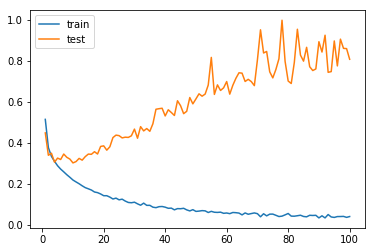

In [16]:
# print(epochs)
#print(epoch_train_loss)

plt.plot(epochs, epoch_train_loss[0], label='train') 
plt.plot(epochs, epoch_test_loss[0], label='test')
plt.legend();

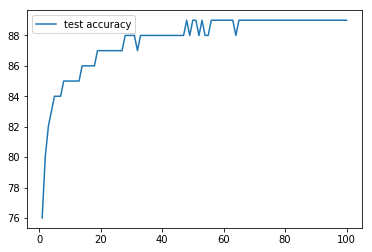

In [12]:
#print(epoch_test_accuracy[0])
plt.plot(epochs, epoch_test_accuracy[0], label='test accuracy') 
plt.legend();

In [17]:
print(epoch_test_accuracy[0])

[tensor(83), tensor(87), tensor(87), tensor(89), tensor(88), tensor(88), tensor(88), tensor(88), tensor(89), tensor(90), tensor(90), tensor(89), tensor(90), tensor(89), tensor(89), tensor(89), tensor(90), tensor(89), tensor(89), tensor(90), tensor(90), tensor(89), tensor(89), tensor(89), tensor(89), tensor(90), tensor(89), tensor(90), tensor(89), tensor(90), tensor(90), tensor(90), tensor(89), tensor(89), tensor(90), tensor(90), tensor(89), tensor(90), tensor(89), tensor(90), tensor(90), tensor(89), tensor(90), tensor(89), tensor(90), tensor(90), tensor(90), tensor(89), tensor(89), tensor(90), tensor(90), tensor(90), tensor(89), tensor(89), tensor(88), tensor(89), tensor(90), tensor(89), tensor(89), tensor(90), tensor(89), tensor(90), tensor(90), tensor(90), tensor(90), tensor(89), tensor(89), tensor(90), tensor(89), tensor(89), tensor(90), tensor(90), tensor(89), tensor(90), tensor(89), tensor(89), tensor(90), tensor(90), tensor(89), tensor(90), tensor(89), tensor(89), tensor(89), ten

In [21]:
the_model = Net()
the_model.load_state_dict(torch.load('model_1.pt'))

the_model.eval()
test([the_model], valid_loader)



Test set:
0: Loss: 0.2985	Accuracy: 8938/10000 (89%)



In [33]:
imgs = []
for batch_idx, (data, target) in enumerate(train_loader):
    print(batch_idx)
    print(data.shape)
    
    print(data[0].shape)
    imgs.append(data[0])
    
    print(target.shape)
    break

0
torch.Size([50, 1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([50])


In [28]:
def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1][0], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

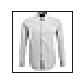

In [29]:
plot_mnist(imgs, (1, 1))

In [20]:
torch.tensor([1]) + torch.tensor([3])

tensor([ 4])

In [21]:
torch.tensor([1]) + torch.tensor([3, 5])

tensor([ 4,  6])

In [20]:
#?F.nll_loss
?nn.NLLLoss